# Analyze `dmsa-phenotype` predictions

## Import `Python` modules

In [1]:
import os
import sys
import glob
import pandas as pd
from collections import defaultdict
import lzma

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import MutableSeq

## Take files with all GISAID sequences and metadata and create new files with a subset of the sequences

In [2]:
# Get a list of strains from a recent 12yr build
ack_df = pd.read_csv('profiles/dmsa-phenotype/sequences/nextstrain_flu_seasonal_h3n2_ha_12y_acknowledgements.tsv', sep='\t')
strains_to_extract = list(ack_df['strain'].unique())
print(len(strains_to_extract), 'strains to extract')

# Get metadata for reference sequence
ref_metadata_df = pd.read_csv('profiles/dmsa-phenotype/sequences/6y_metadata_w_HK19.tsv.xz', sep='\t')
ref_metadata_df = ref_metadata_df[ref_metadata_df['strain'] == 'A/HK/45/2019']

# Read in metadata for all sequences, then write an output with subset from 12yr build plus reference
all_metadata_df = pd.read_csv('profiles/dmsa-phenotype/sequences/metadata.tsv.xz', sep='\t')
metadata_12yr_df = all_metadata_df[all_metadata_df['strain'].isin(strains_to_extract)]
output_f = 'profiles/dmsa-phenotype/sequences/12y_metadata.tsv'
if not os.path.isfile(output_f):
    print(f'Extracted {len(metadata_12yr_df)} strains from metadata')
    metadata_12yr_df = pd.concat([metadata_12yr_df, ref_metadata_df])
    metadata_12yr_df.to_csv(output_f, index=False)

# Get FASTA entry for reference sequence 
input_f = 'profiles/dmsa-phenotype/sequences/6y_sequences_w_HK19.fasta.xz'
with lzma.open(input_f, mode='rt', encoding='utf-8') as f:
    for record in SeqIO.parse(f, 'fasta'):
        if record.id == 'A/HK/45/2019':
            ref_id = record.id
            ref_seq = record.seq

# Read in FASTA of all sequences, then write an output with subset from 12yr build plus reference
input_f = 'profiles/dmsa-phenotype/sequences/sequences.fasta.xz'
output_f = 'profiles/dmsa-phenotype/sequences/12y_sequences.fasta'
if not os.path.isfile(output_f):
    seqs_extracted = 0
    with lzma.open(input_f, mode='rt', encoding='utf-8') as fasta_f:
        with open(output_f, 'w') as f:
            for record in SeqIO.parse(fasta_f, 'fasta'):
                if record.id in strains_to_extract:
                    f.write(f'>{record.id}\n{record.seq}\n')
                    seqs_extracted += 1
            f.write(f'>{ref_id}\n{ref_seq}\n')
    print(f'Extracted {seqs_extracted} from the FASTA file')

1478 strains to extract


## Curate files with mutational effects

First, read in files with all mutational effects and then make new files with only mutations that pass certain filters, such as the number of times a mutation was observed in the experiment.

In [3]:
times_seen = 3
n_models = 2
mut_effects_dir = 'profiles/dmsa-phenotype/antibody_escape/'
filtered_mut_effects_dir = os.path.join(mut_effects_dir, 'filtered_data/')
if not os.path.isdir(filtered_mut_effects_dir):
    os.makedirs(filtered_mut_effects_dir)
fs = glob.glob(os.path.join(mut_effects_dir, '*_avg.csv'))
for f in fs:
    output_f = f.replace(mut_effects_dir, filtered_mut_effects_dir)
    if not os.path.isfile(output_f):
        df = pd.read_csv(f)
        starting_len = len(df)
        df = df[
            (df['times_seen'] >= times_seen) &
            (df['n_models'] >= n_models)
        ]
        ending_len = len(df)
        #print(starting_len, ending_len, os.path.basename(f))
        if ending_len > 0:
            df.to_csv(output_f, index=False)

Get data on the cohort associated with a given serum sample

In [4]:
cohort_dict = {
    'children' : [
        3944,
        2389,
        2323,
        2388,
        3973,
        4299,
        4584,
        2367,
    ],
    'teenagers' : [
        2350,
        2365,
        2382,
        3866,
        2380,
        3856, # outlier
        3857,
        3862,
    ],
    'adults' : [
        '33C',
        '34C',
        '197C',
        '199C',
        '215C',
        '210C',
        '74C',
        '68C',
        '150C',
        '18C',
    ],
    'elderly' : [
        'AUSAB-13'
    ],
    'infant' : [
        2462
    ]
}
serum_to_cohort_dict = defaultdict(list)
for (cohort, sera) in cohort_dict.items():
    for serum in sera:
        serum_to_cohort_dict['cohort'].append(cohort)
        serum_to_cohort_dict['serum'].append(str(serum))
serum_to_cohort_df = pd.DataFrame(serum_to_cohort_dict)

Average mutational effects across all sera in a given cohort

In [5]:
cohorts = [
    'children', 'teenagers', 'adults'
    ]
for cohort in cohorts:
    sera = cohort_dict[cohort]
    dfs = []
    for serum in sera:
        f = os.path.join(filtered_mut_effects_dir, f'{serum}_avg.csv')
        assert os.path.isfile(f)
        df = pd.read_csv(f)
        df['serum'] = serum
        dfs.append(df)
    df = pd.concat(dfs)
    df.groupby(['mutation'])[['escape_median']].mean().reset_index()
    output_f = os.path.join(filtered_mut_effects_dir, f'avg_{cohort}.csv')
    if not os.path.isfile(output_f):
        df.to_csv(output_f, index=False)

## Read in escape scores and metadata

In [6]:
# Read in escape scores
yr = 12
resultsdir = f'builds/flu_seasonal_h3n2_{yr}y/ha/dmsa-phenotype/frances-escape-2023-10-16/'
fs = glob.glob(os.path.join(resultsdir, '*.csv'))
dfs = []
for f in fs:
    serum = os.path.basename(f).replace('_avg.csv_variant_escape_prediction.csv', '')
    df = pd.read_csv(f)
    df['serum'] = serum
    df.rename(columns={'pred_phenotype':'escape_score'}, inplace=True)
    dfs.append(df)
escape_df = pd.concat(dfs)

# Drop escape scores for internal nodes
escape_df = escape_df[~escape_df['strain'].str.contains('NODE')]

# Add metadata
metadata_df = pd.read_csv(f'profiles/dmsa-phenotype/sequences/{yr}y_metadata.tsv.xz', sep=',')
metadata_df['date'] = pd.to_datetime(metadata_df['date'], errors='coerce')
escape_df = escape_df.merge(metadata_df, on='strain')
escape_df = escape_df.merge(serum_to_cohort_df, on='serum', how='left')

# Add a column giving time in years since a reference date
escape_df['time'] = (escape_df['date'] - pd.to_datetime('2020-01-01')).dt.days / 365

Identify sites that have strong mutational effects in the DMS data

In [7]:
sera_to_analyze = cohort_dict['children'] + cohort_dict['teenagers'] + cohort_dict['adults']
dfs = []
for serum in sera_to_analyze:
    f = f'profiles/dmsa-phenotype/antibody_escape/filtered_data/{serum}_avg.csv'
    df = pd.read_csv(f)
    df['serum'] = serum
    dfs.append(df)
mut_effects_df = pd.concat(dfs)
cutoff = 0.25
important_sites = mut_effects_df[
    (mut_effects_df['escape_median'] > cutoff) |
    (mut_effects_df['escape_median'] < -cutoff)
]['site'].unique()
len(important_sites)

291

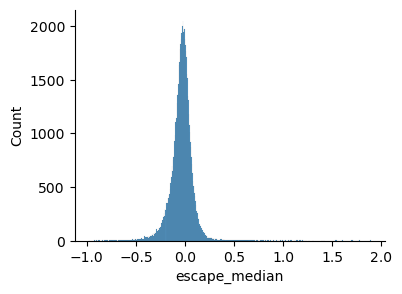

In [8]:
plt.figure(figsize=[4,3])
sns.histplot(x='escape_median', data=mut_effects_df)
sns.despine()
plt.show()

What are the disallowed mutations that are popping up?

In [9]:
# Get a list of all disallowed subs
disallowed_subs = []
data = escape_df[escape_df['disallowed_aa_substitutions'].notnull()]
for subs in data['disallowed_aa_substitutions']:
    disallowed_subs += subs.split(' ')

# Make a dataframe with counts
counts_dict = defaultdict(list)
(subs, counts) = np.unique(disallowed_subs, return_counts = True)
for (sub, count) in zip(subs, counts):
    counts_dict['sub'].append(sub)
    counts_dict['count'].append(count)
counts_df = pd.DataFrame(counts_dict)
counts_df['site'] = counts_df['sub'].apply(lambda x: int(x[1:-1]))
counts_df['important_site'] = counts_df['site'].apply(lambda x: x in important_sites)
counts_df.sort_values('count', ascending=False).head(n=20)

,sub,count,site,important_site
9,D104G,1989,104,True
27,F79V,1248,79,False
62,K2E,858,2,False
74,L194P,585,194,True
122,S205F,507,205,False
87,M168V,429,168,True
38,I140R,273,140,True
73,L157I,273,157,True
107,P221L,234,221,True
10,D104N,156,104,True


In [12]:
mut_effects_df[
    ((mut_effects_df['escape_median'] > cutoff) |
    (mut_effects_df['escape_median'] < -cutoff)) &
    (mut_effects_df['site'] == 104)
]

,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_min_magnitude,escape_std,n_models,times_seen,frac_models,serum
647,1,104,D,Y,D104Y,-0.2861,-0.2861,-0.123,0.2307,2,3.5,1.0,2323


<Axes: xlabel='n_disallowed_aa_substitutions', ylabel='Count'>

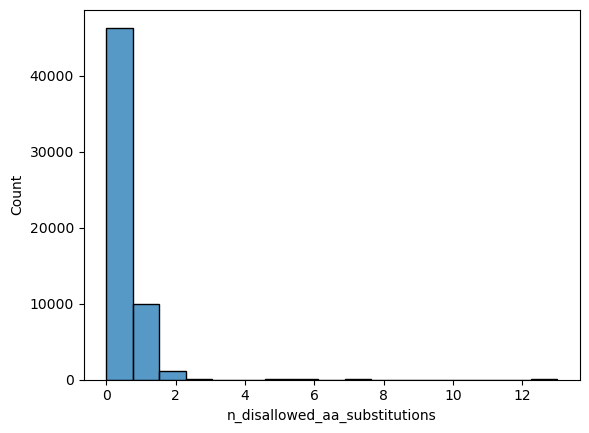

In [10]:
sns.histplot(x='n_disallowed_aa_substitutions', data=escape_df)

In [11]:
print(len(escape_df))
print(sum(escape_df['disallowed_aa_substitutions'].notnull()))

57642
11303


## Analyze distributions of escape scores

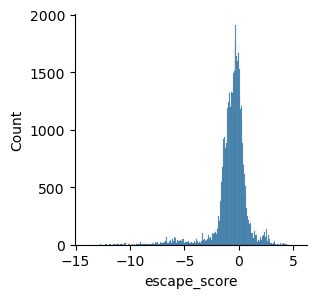

In [37]:
plt.figure(figsize=[3,3])
sns.histplot(x='escape_score', data=escape_df)
sns.despine()
plt.show()

For each strain, plot the average escape score across all serum samples in a given cohort.

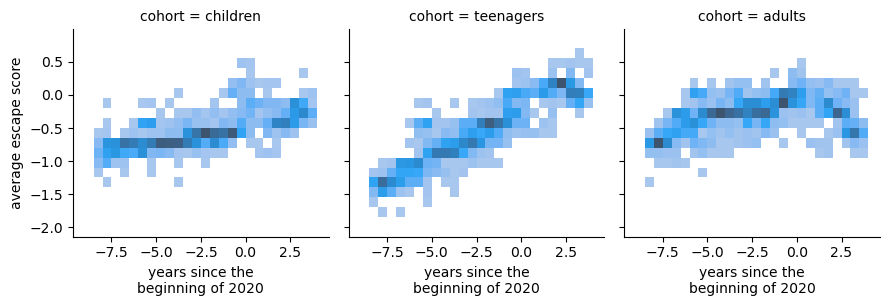

In [40]:
data = escape_df.groupby(['strain', 'cohort'])[['escape_score', 'time']].mean().reset_index()
data = data.merge(metadata_df, on='strain')
cohort_order = [
    #'infant',
    'children', 'teenagers', 'adults',
    # 'elderly'
]
binsx = np.arange(-9, 4.5, 0.5)
binsy = np.arange(-2, 1, 0.15)
g = sns.FacetGrid(data, col="cohort", col_order=cohort_order)
g.map(
    sns.histplot, "time", "escape_score",
    bins=(binsx, binsy)
)
g.set(ylabel='average escape score', xlabel='years since the\nbeginning of 2020')
plt.show()

Plot data for all serum samples in a given cohort

infant


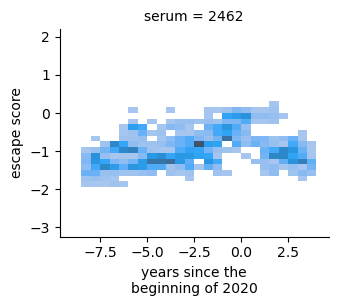

children


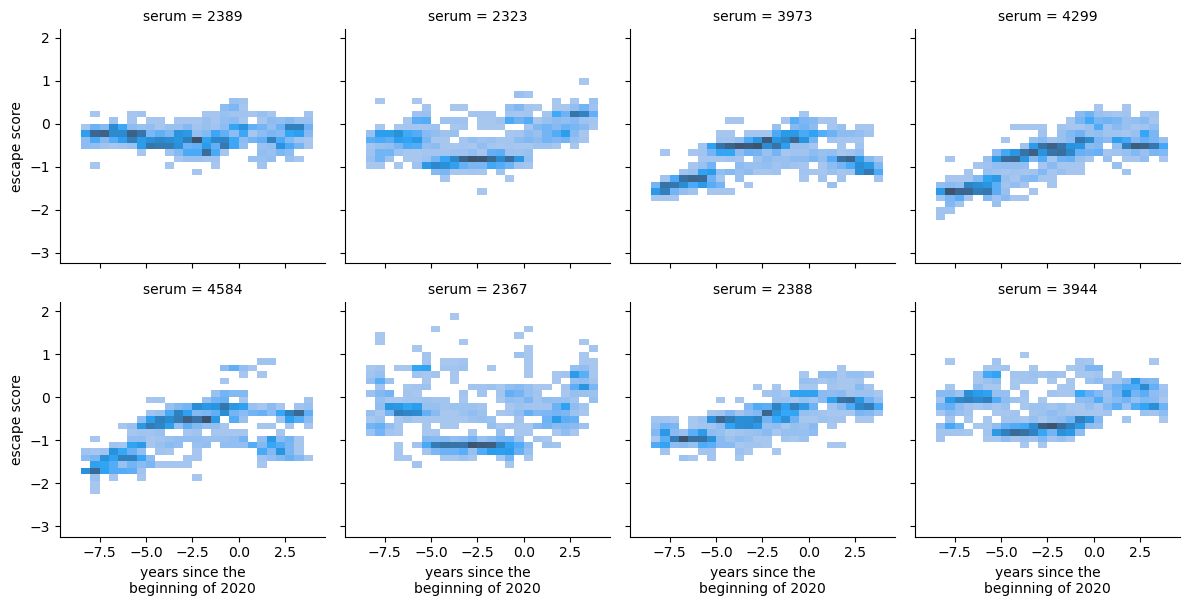

teenagers


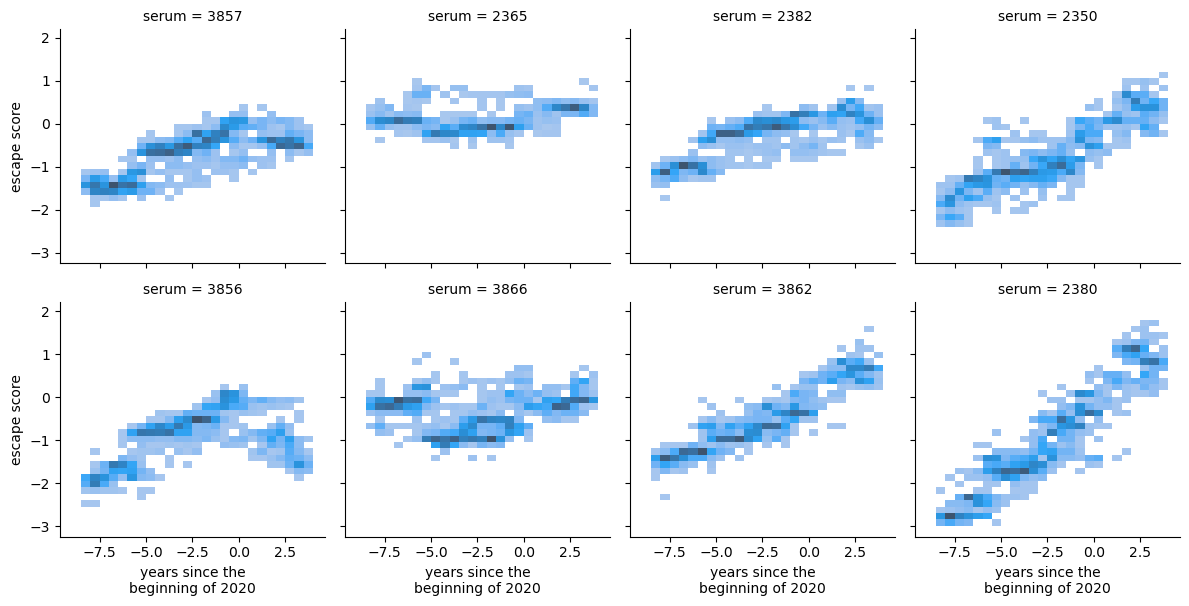

adults


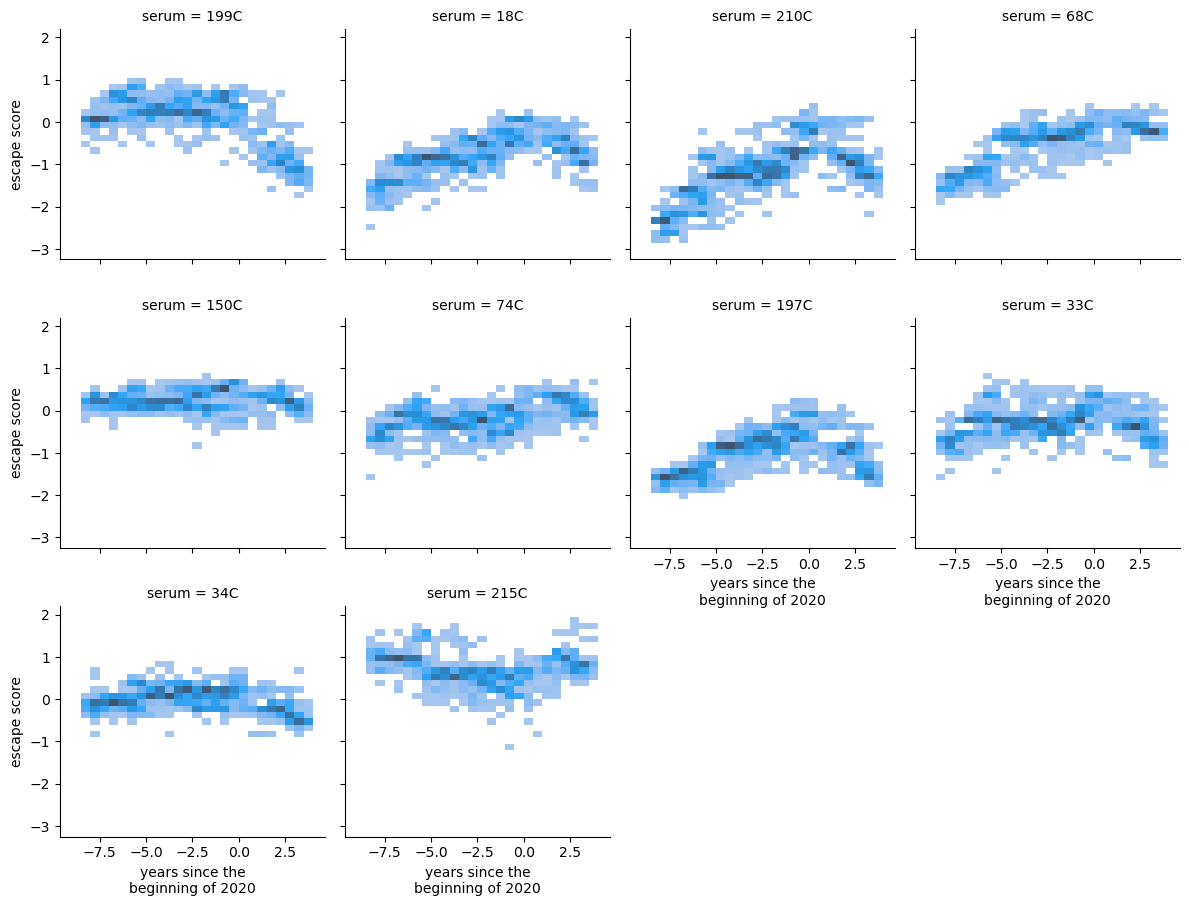

In [42]:
cohorts = ['infant', 'children', 'teenagers', 'adults']
for cohort in cohorts:
    print(cohort)
    data = escape_df[escape_df['cohort'] == cohort]
    binsx = np.arange(-9, 4.5, 0.5)
    binsy = np.arange(-3, 2, 0.15)
    g = sns.FacetGrid(data, col="serum", col_wrap=4)
    g.map(
        sns.histplot, "time", "escape_score",
        bins=(binsx, binsy)
    )
    g.set(ylabel='escape score', xlabel='years since the\nbeginning of 2020')
    plt.show()

Questions/observations for Frances:
* numbering scheme reality check. Is it ok that we left out the signal peptide?
    * the signal peptide was not mutated in the experiment
* what is the range of beta values from the experiments?
    * the magnitude seems lower than other datasets. Sense of why that might be?
* is it valid to average escape across sera without normalizing betas?
    * probably ok, but will run by Jesse. Maybe I'll plot distributions
* what are the mutations you know appear in nature and do we capture those in the dmsa analysis?
    * H156S (e.g., 2380)
    * S144N (e.g., 2323)
    * 137, 138, 193 (e.g., 2367) -- 193 important
* actually, the evolution is somewhat punctuated
    * nextstrain scatter plot is a good way to view this

* would it be worth including more sequences in the build before -2.5 to get better support for the trend?
    * seems like there are two main clusters at around -1 and 2.5. Worth trying to sample one more cluster at around -4.5?

* To dos
    * average betas before making predictions and then run those through
    * run it on the 12yr build
    * color scale
    * check for mutations without DMS data?

Analyze the distribution of betas for a given sample

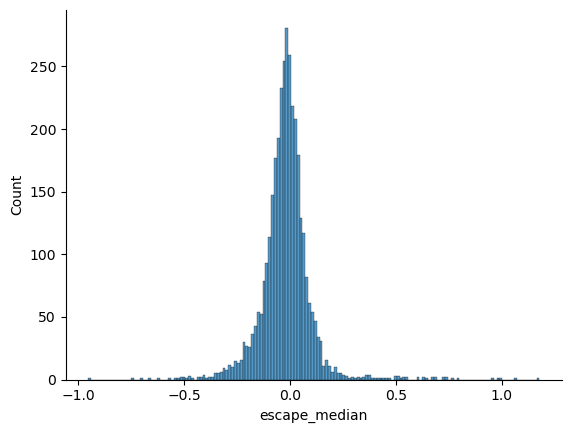

In [32]:
df = pd.read_csv('profiles/dmsa-phenotype/antibody_escape/2380_avg.csv')
sns.histplot(x='escape_median', data=df)
sns.despine()
plt.show()

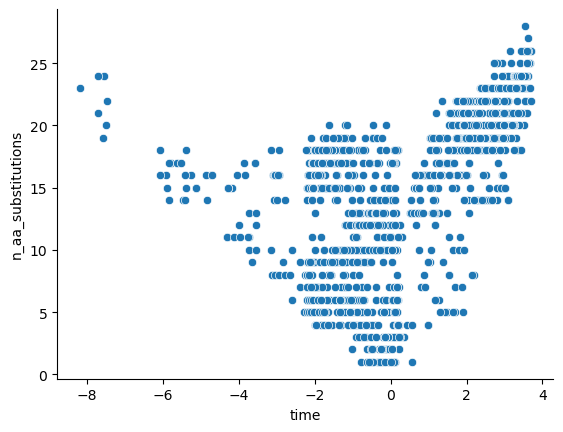

In [22]:
data = escape_df.drop_duplicates('strain').copy()
data.dropna(subset=['aa_substitutions'], inplace=True)
data['n_aa_substitutions'] = data['aa_substitutions'].apply(lambda x: len(x.split(' ')))
sns.scatterplot(x='time', y='n_aa_substitutions', data=data)
sns.despine()
plt.show()

In [26]:
aa_subs = data[
    (data['n_aa_substitutions'] > 20) &
    (data['time'] > 2)
].iloc[0]['aa_substitutions'].split(' ')
aa_subs

['E50K',
 'F79V',
 'K83E',
 'Y94N',
 'A128T',
 'T131K',
 'K135T',
 'F137S',
 'S138A',
 'I140K',
 'Y159N',
 'T160I',
 'L164Q',
 'G186D',
 'D190N',
 'Y195F',
 'I242M',
 'N312S',
 'S480A',
 'N489S',
 'V529I']

In [76]:
escape_df.groupby('cohort')['serum'].value_counts()

cohort     serum   
adults     150C        1350
           18C         1350
           197C        1350
           199C        1350
           210C        1350
           215C        1350
           33C         1350
           34C         1350
           68C         1350
           74C         1350
children   2323        1350
           2367        1350
           2388        1350
           2389        1350
           3944        1350
           3973        1350
           4299        1350
           4584        1350
elderly    AUSAB-13    1350
infant     2462        1350
teenagers  2350        1350
           2365        1350
           2380        1350
           2382        1350
           3856        1350
           3857        1350
           3862        1350
           3866        1350
Name: serum, dtype: int64

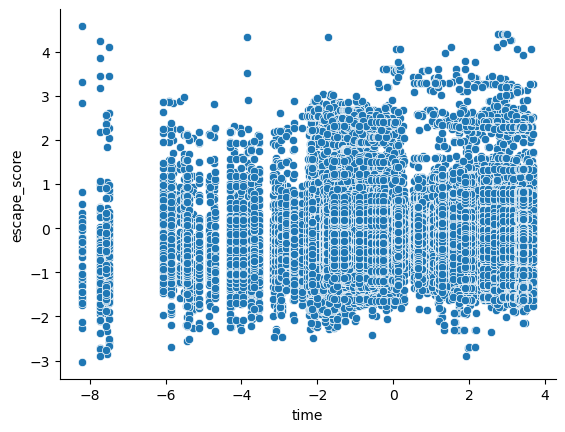

In [10]:
sns.scatterplot(x='time', y='escape_score', data=escape_df)
sns.despine()
plt.show()

In [54]:
df = escape_df.groupby('serum')[['escape_score']].agg('max')
df.sort_values('escape_score', ascending=False)

,escape_score
serum,
AUSAB-13,4.5836
ferret_2,3.5099
5G04,3.3525
AUSAB-07,2.8338
1C04,2.6170
215C,2.0732
ferret_3,1.8874
2367,1.8632
ferret_1,1.8373
